In [1]:
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image


## Setup

### Define data and model paths 

In [2]:
# Data path
BASE_DIR = Path("/Users/ma/Library/CloudStorage/GoogleDrive-mdhornstein@gmail.com/My Drive/cv_paleontology/")
FID_DATA_PATH = BASE_DIR / "data" / "reduced-FID"

# Model path
MODEL_PATH = Path("../models/fid_classification/tf1_from_community_allow_train/1")

In [3]:
!ls "{MODEL_PATH}"

saved_model.pb variables


In [3]:
!ls /Users/ma/Library/CloudStorage/GoogleDrive-mdhornstein@gmail.com/My\ Drive/cv_paleontology/data

exp1_trilobite_ammonoid reduced-FID


In [8]:
print("Loading model...")
model = tf.saved_model.load(str(MODEL_PATH))   # <-- TF1-style load
print("Model loaded!")

Loading model...
Model loaded!


In [9]:
infer = model.signatures["serving_default"]
print("Signature keys:", list(model.signatures.keys()))
print("Inputs:", infer.structured_input_signature)
print("Outputs:", infer.structured_outputs)

Signature keys: ['serving_default']
Inputs: ((), {'input': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input')})
Outputs: {'logits': <tf.Tensor 'InceptionResnetV2/Logits/Logits/BiasAdd:0' shape=(None, 50) dtype=float32>, 'predictions': <tf.Tensor 'predictions:0' shape=(None, 50) dtype=float32>}


In [5]:
# Preprocessing for 299x299 input
def preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # normalize [0,1]
    return x.astype(np.float32)

### Apply model to a dummy image 

In [11]:
# Create a dummy image (batch size 1, 299x299 RGB)
dummy = np.random.rand(1, 299, 299, 3).astype(np.float32)

# Run inference
outputs = infer(input=tf.convert_to_tensor(dummy))

print("Available outputs:", outputs.keys())
print("Logits shape:", outputs["logits"].shape)
print("Predictions shape:", outputs["predictions"].shape)

# Check top prediction
preds = outputs["predictions"].numpy()
top_class = np.argmax(preds, axis=1)[0]
print("Top predicted class index:", top_class)
print("Prob distribution (first 5 classes):", preds[0, :5])

Available outputs: dict_keys(['logits', 'predictions'])
Logits shape: (1, 50)
Predictions shape: (1, 50)
Top predicted class index: 47
Prob distribution (first 5 classes): [0.00133699 0.00484791 0.01589936 0.0226378  0.01736049]


### Example: classify a single image

In [12]:
# Get class names from directory structure
class_names = sorted([d.name for d in FID_DATA_PATH.iterdir() if d.is_dir()])
print("Classes:", class_names)

Classes: ['agnatha', 'ammonoid', 'amphibian', 'angiosperm', 'avialae', 'belemnite', 'bivalve', 'blastoid', 'bone_fragment', 'brachiopod', 'bryozoan', 'chelicerate', 'chondrichthyes', 'conodont', 'coral', 'crinoid', 'crocodylomorph', 'crustacean', 'echinoid', 'foraminifer', 'gastropod', 'graptolite', 'gymnosperm', 'insect', 'mammal', 'mammal_teeth', 'marine_reptile', 'myriapod', 'nautiloid', 'ophiuroid', 'ornithischian', 'osteichthyes', 'ostracod', 'petrified_wood', 'placoderms', 'pteridophyte', 'pterosaurs', 'radiolarian', 'reptile_teeth', 'sauropodomorph', 'shark_teeth', 'snake', 'sponge', 'spore_or_pollen', 'starfish', 'stromatolite', 'theropod', 'trace_fossil', 'trilobite', 'turtle']


In [15]:
# Choose one clade + one image
class_names = sorted([d.name for d in FID_DATA_PATH.iterdir() if d.is_dir()])
chosen_clade = class_names[0]  # <-- pick the first class (or change manually)
pattern = str(FID_DATA_PATH / chosen_clade / "*")

print(f"Chosen clade: {chosen_clade}")
print(f"Pattern: {pattern}")

Chosen clade: agnatha
Pattern: /Users/ma/Library/CloudStorage/GoogleDrive-mdhornstein@gmail.com/My Drive/cv_paleontology/data/reduced-FID/agnatha/*


In [17]:
dataset = tf.data.Dataset.list_files(pattern, shuffle=True, seed=42)
img_path = next(iter(dataset.take(1))).numpy().decode("utf-8")
print("Testing image:", img_path)

Testing image: /Users/ma/Library/CloudStorage/GoogleDrive-mdhornstein@gmail.com/My Drive/cv_paleontology/data/reduced-FID/agnatha/51.fuxianhuia-protensa-l.jpg


In [20]:
# Preprocess
img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
x = x.astype(np.float32)

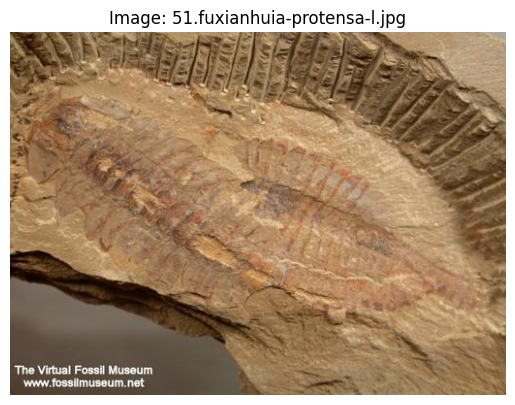

In [ ]:
filename = Path(img_path).name

# Load original image
orig_img = tf.keras.utils.load_img(img_path)  # full resolution

# Preprocess (resize + scale)
img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
x = x.astype(np.float32)

# Plot
plt.imshow(orig_img)
plt.axis("off")
plt.title(f"Image: {filename}")
plt.show()

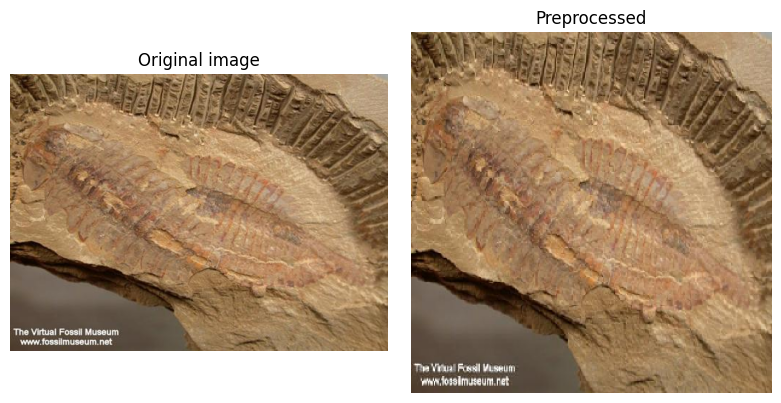

In [25]:
# Plot original vs preprocessed
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig_img)
plt.axis("off")
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(img)
plt.axis("off")
plt.title(f"Preprocessed")

plt.tight_layout()
plt.show()

In [26]:
print("Input shape to model:", x.shape)


Input shape to model: (1, 299, 299, 3)


In [27]:
# Run inference
outputs = infer(input=tf.convert_to_tensor(x))
preds = outputs["predictions"].numpy()
print("Raw prediction vector shape:", preds.shape)

Raw prediction vector shape: (1, 50)


In [28]:
# Checks
print("Sum of probabilities:", np.sum(preds[0]))
print("Max probability:", np.max(preds[0]))

Sum of probabilities: 1.0
Max probability: 0.997077


In [38]:
# Top-k results
top_k = 5
top_indices = preds[0].argsort()[-top_k:][::-1]
top_labels = [class_names[i] for i in top_indices]
top_probs = preds[0][top_indices]
print("\nTop predictions:")
for i in top_indices:
    print(f"  {class_names[i]}: {preds[0][i]:.4f}")


Top predictions:
  agnatha: 0.9971
  chondrichthyes: 0.0016
  trilobite: 0.0008
  mammal: 0.0001
  starfish: 0.0001


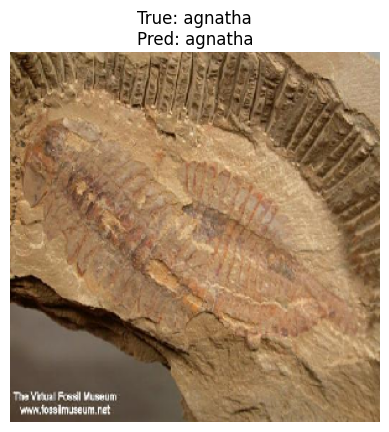

In [32]:
# Plot
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {chosen_clade}\nPred: {class_names[top_indices[0]]}")
plt.show()


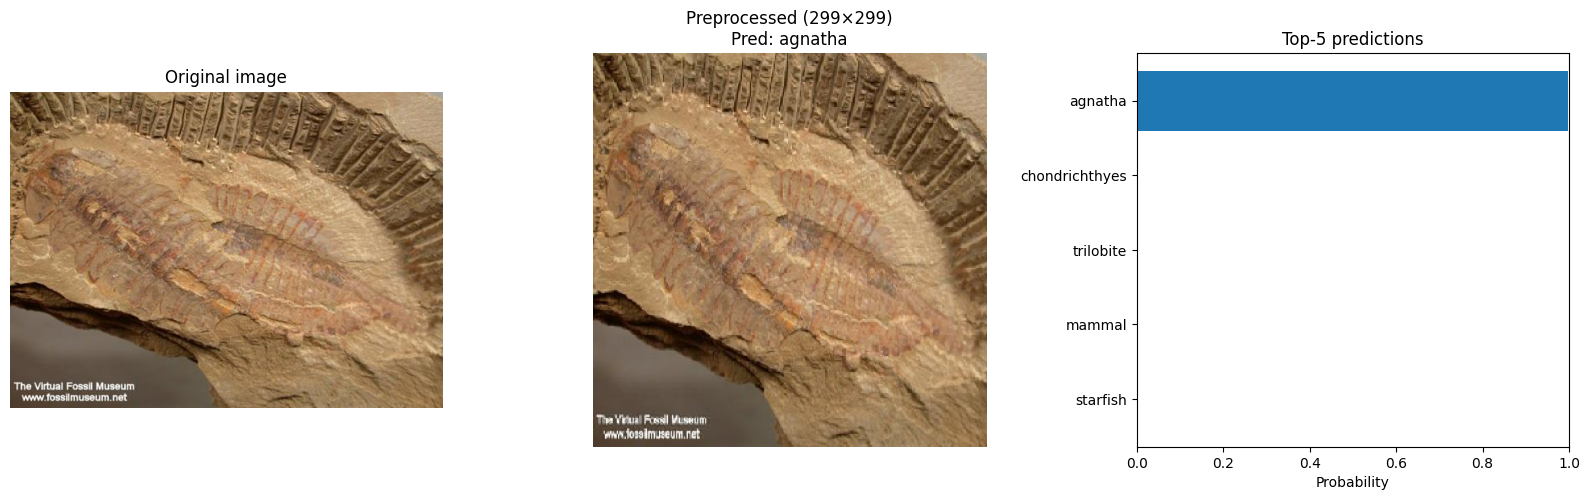

In [39]:
# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original image
axes[0].imshow(orig_img)
axes[0].axis("off")
axes[0].set_title("Original image")

# Preprocessed image
axes[1].imshow(img)
axes[1].axis("off")
axes[1].set_title(f"Preprocessed (299×299)\nPred: {top_labels[0]}")

# Bar chart for top-5 predictions
axes[2].barh(range(top_k), top_probs[::-1])
axes[2].set_yticks(range(top_k))
axes[2].set_yticklabels(top_labels[::-1])
axes[2].set_xlim(0, 1)
axes[2].set_xlabel("Probability")
axes[2].set_title("Top-5 predictions")

plt.tight_layout()
plt.show()

In [31]:
# %%
# Try loading as Keras model (if available)
try:
    keras_model = tf.keras.models.load_model(str(MODEL_PATH))
    print("Successfully loaded as Keras model!")
    print("\nModel layers:")
    for i, layer in enumerate(keras_model.layers):
        print(f"{i}: {layer.name} - {layer.__class__.__name__}")
except Exception as e:
    print(f"Could not load as Keras model: {e}")
    print("\nWe'll need to work with the SavedModel signature instead.")
    keras_model = None

Could not load as Keras model: list index out of range

We'll need to work with the SavedModel signature instead.


TimeoutError: [Errno 60] Operation timed out

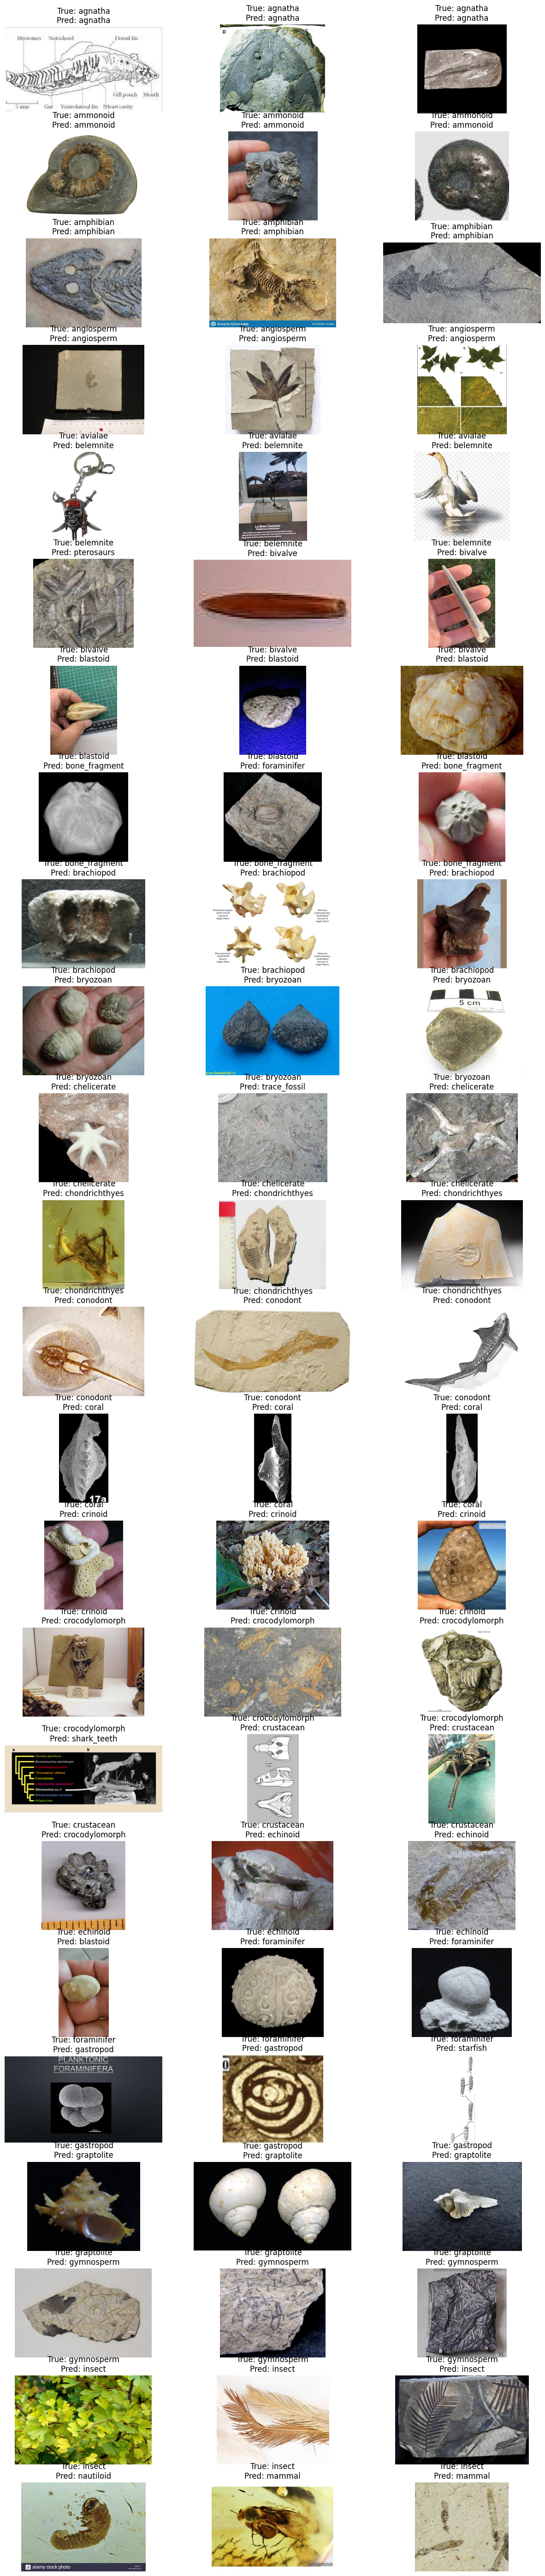

In [45]:
# Display predictions for a few images from each class
num_samples_per_class = 3
plt.figure(figsize=(15, len(class_names) * 3))

plot_index = 1
for class_name in class_names:
    img_dir = FID_DATA_PATH / class_name
    sample_imgs = list(img_dir.glob("*"))[:num_samples_per_class]

    for img_path in sample_imgs:
        x = preprocess_image(img_path)

        # Call the TF1 model
        outputs = infer(input=tf.convert_to_tensor(x))

        # Grab predictions (softmax)
        preds = outputs["predictions"].numpy()
        pred_class_idx = np.argmax(preds, axis=1)[0]
        pred_class = class_names[pred_class_idx]

        # Plot image + prediction
        plt.subplot(len(class_names), num_samples_per_class, plot_index)
        plt.imshow(image.load_img(img_path))
        plt.axis("off")
        plt.title(f"True: {class_name}\nPred: {pred_class}")
        plot_index += 1

plt.tight_layout()
plt.show()